# Implementing a basic diffusion model
Forming basics of physics and ML

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
## Forward diffusion process
def linear_beta_schedule(timesteps, start = 1e-4, end = 0.02):
    return torch.linspace(start, end, timesteps)

timesteps = 200
betas = linear_beta_schedule(timesteps)
alphas = 1.0 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

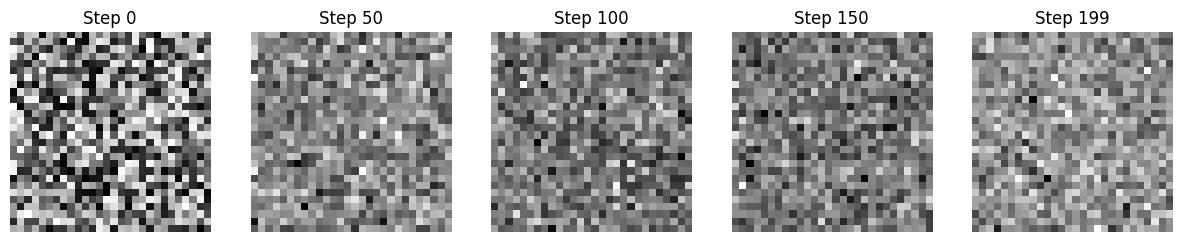

In [4]:
def forward_diffusion_sample(x0, t):
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])
    sqrt_one_minus_alpha_hat = torch.sqrt(1-alpha_hat[t])
    eps = torch.randn_like(x0)
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * eps, eps

x0 = torch.rand((1, 1, 28, 28))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx, step in enumerate([0, 50, 100, 150, 199]):
    noisy_img, _ = forward_diffusion_sample(x0, step)
    axes[idx].imshow(noisy_img.squeeze().detach().numpy(), cmap="gray")
    axes[idx].set_title(f"Step {step}")
    axes[idx].axis("off")
plt.show()

In [6]:
# Basic UNet for denosing
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(1, 32)
        self.down2 = DoubleConv(32, 64)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(64, 128)

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_conv1 = DoubleConv(128, 64)
        self.up_conv2 = DoubleConv(64, 32)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.pool(x1)
        x2 = self.down2(x2)

        # Bottleneck
        x3 = self.pool(x2)
        x3 = self.bottleneck(x3)

        # Decoder
        x = self.up(x3)
        x = self.up_conv1(x)
        x = self.up(x)
        x = self.up_conv2(x)
        return self.final(x)
    
# create model
model = UNet()
x = torch.randn(1, 1, 28, 28)
print("UNet output shape:", model(x).shape)


UNet output shape: torch.Size([1, 1, 28, 28])


In [7]:
def get_loss(model, x0, t):
    """Loss: predict noise added at step t."""
    x_noisy, noise = forward_diffusion_sample(x0, t)
    noise_pred = model(x_noisy)
    return F.mse_loss(noise_pred, noise)


# Dummy training setup
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Fake dataset: random tensors
images = torch.rand((16, 1, 28, 28))


for epoch in range(3):
    optimizer.zero_grad()
    t = torch.randint(0, timesteps, (1,)).item() # random timestep
    loss = get_loss(model, images, t)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Step {t}, Loss: {loss.item():.4f}")

Epoch 1, Step 196, Loss: 1.0141
Epoch 2, Step 138, Loss: 0.9946
Epoch 3, Step 106, Loss: 0.9931
